### 学習済みモデルによる推論
- Google Colaboratoryにて実行
- BERTの事前学習モデル（公開データセットでファインチューニング済み）を用いて感情分析の推論を行なった。

In [ ]:
# ライブラリインストール
!pip install transformers
!pip install torch
!pip install accelerate -U
!pip install fugashi
!pip install ipadic


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 72.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=7a8ba7656423f91cd71493c3a2e8e82574ad758b221d798ce8a17880a0282ef0
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [ ]:
# import
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
# ディレクトリ・ファイル名・設定など
loading_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/text_classification/"
model_path = "text-classification-bert_fine-tuned/"
data_dir_for_prediction = "prediction_data/input/"
filename_for_prediction = "ここにファイル名を記述"
text_col = "review"

# 推論対象データ
df_for_prediction = pd.read_csv(loading_dir + data_dir_for_prediction + filename_for_prediction)
df_for_prediction = df_for_prediction[text_col]
df_for_prediction.drop_duplicates(inplace=True)


In [ ]:
df_for_prediction


0                                       世界に誇る首都東京の玄関口🚇🚉🚅🌍
1       東京駅レンガ造りの駅舎と周りを取り囲むKITTEや新丸ビルなどの高層ビル群皇居に繋がる行幸通...
2                                                   工事が進む
3       東京駅構内は工事が進み、通路が広くなり、店舗も多くなりました。土産を買う店も多くあり、食事が...
4                                         すっかり観光地になってしまった
                              ...                        
2134                                  東京駅にあまり行かない者ですが・・・。
2135    この前久しぶりに東京駅に行ってきました。（新幹線に忘れ物をしたので。）とにかく広いな～～～っ...
2136                                                意外に質素
2137    駅中にあるショッピングゾーンに行きました。意外でした。新幹線の始発駅とは思えないほどの質素な...
2139    内部が複雑に感じます。慣れないと乗り換えに苦戦するかもしれません。しかし構内にはたくさんお店...
Name: review, Length: 1773, dtype: object

### 推論

In [ ]:
def predict_sentiments_by_loaded_model(
    text_list,
    model_path,
  ):
  """
  リストを読み込み推論を行う
  """

  # デバイス設定
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # トークナイザ・モデル読み込み
  tokenizer = AutoTokenizer.from_pretrained(model_path)
  model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

  # テキストデータの推論
  sentiment_list = []
  positive_score_list = []
  neutral_score_list = []
  negative_score_list = []

  for text in text_list:
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors= 'pt')

    model.eval()

    with torch.no_grad():
      outputs = model(
          inputs["input_ids"].to(device),
          inputs["attention_mask"].to(device),
      )
    # print(f"outputs.logits: {outputs.logits}")

    # logitsを確率に変換
    probabilities = F.softmax(outputs.logits, dim=1)[0].cpu().numpy().tolist()
    probabilities = [round(prob, 5) for prob in probabilities]
    # 各分類の確率をリストに格納
    positive_score_list.append(probabilities[0])
    neutral_score_list.append(probabilities[1])
    negative_score_list.append(probabilities[2])

    # logitsを推論ラベルに変換・リストへ格納
    pred_id = np.argmax(outputs.logits.to('cpu').detach(), axis=1).tolist()[0]
    # print(pred_id)
    pred_label = model.config.id2label[pred_id]
    sentiment_list.append(pred_label)

  df_sentiments = pd.DataFrame(
    data = {
        'text': text_list,
        'sentiment': sentiment_list,
        'score_positive': positive_score_list,
        'score_neutral': neutral_score_list,
        'score_negative': negative_score_list
    }
  )

  return df_sentiments

# 推論
review_list = df_for_prediction.to_list()
df_sentiment_for_reviews = predict_sentiments_by_loaded_model(
    text_list = review_list,
    model_path = loading_dir + model_path,
)


In [ ]:
df_sentiment_for_reviews


,text,sentiment,score_positive,score_neutral,score_negative
0,世界に誇る首都東京の玄関口🚇🚉🚅🌍,positive,0.95412,0.04033,0.00555
1,東京駅レンガ造りの駅舎と周りを取り囲むKITTEや新丸ビルなどの高層ビル群皇居に繋がる行幸通...,positive,0.99736,0.00201,0.00062
2,工事が進む,neutral,0.02802,0.94148,0.03050
3,東京駅構内は工事が進み、通路が広くなり、店舗も多くなりました。土産を買う店も多くあり、食事が...,positive,0.76304,0.22750,0.00946
4,すっかり観光地になってしまった,neutral,0.24166,0.59756,0.16078
...,...,...,...,...,...
1768,東京駅にあまり行かない者ですが・・・。,neutral,0.05714,0.90784,0.03502
1769,この前久しぶりに東京駅に行ってきました。（新幹線に忘れ物をしたので。）とにかく広いな～～～っ...,neutral,0.00296,0.77481,0.22223
1770,意外に質素,negative,0.00368,0.07651,0.91981
1771,駅中にあるショッピングゾーンに行きました。意外でした。新幹線の始発駅とは思えないほどの質素な...,neutral,0.01721,0.95501,0.02778


In [ ]:
# 推論結果の保存
output_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/text_classification/prediction_data/output/"
output_file = "sentiments_classification_result_for_texts.csv"
os.makedirs(output_dir, exist_ok = True)
df_sentiment_for_reviews.to_csv(output_dir + output_file, encoding = "utf-8_sig", index = False)


### 分類結果の可視化

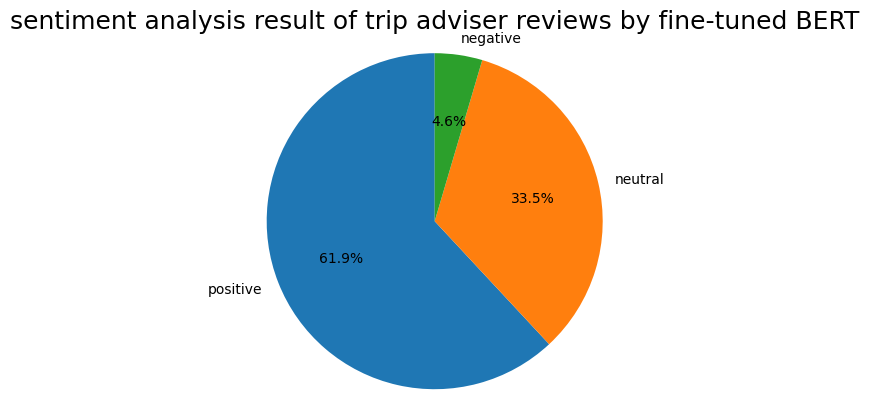

In [ ]:
# ポジ・ネガ・中立の各比率算出
def visualize_sentiment_distribution(
    df: pd.DataFrame = None,
    title: str = None,
    output_dir: str = "../output/",
    output_file: str = None
) -> None:
    # "sentiment"列に入っている各要素の出現回数をカウントする
    sentiment_counts = df['sentiment'].value_counts()
    # 各要素の割合を計算する
    sentiment_ratios = sentiment_counts / len(df)
    # 円グラフを描画する
    labels = df['sentiment'].unique().tolist()
    sizes = sentiment_ratios.tolist()
    plt.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 90)
    plt.title(title, fontsize = 18)
    plt.axis('equal')
    plt.savefig(output_dir + output_file)
    plt.show()

# 分析結果読込
result_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/text_classification/prediction_data/output/"
result_csv_file= "sentiments_classification_result_for_texts.csv"
df_result = pd.read_csv(result_dir + result_csv_file)

# ポジネガ判定結果を円グラフで可視化
output_bert = "bert_sentiment_ratio_for_texts.png"
visualize_sentiment_distribution(
    df=df_result,
    title="sentiment analysis result of texts by fine-tuned BERT",
    output_dir=result_dir,
    output_file=output_bert
)
